In [274]:
!sudo pip install pillow

#Predicting Deep Fashion Attributes - A Task 

## Task Summary - 

Hello! 
This notebook uses the dataset provided by FlixStock, as per their deep learning assessement. The dataset consisted of a csv file having the images path and their attributes. It was accompanied by an images folder consisting of all the images.
The following approach was followed in order to train and predict on the given images


1.   The "attributes.csv" was read as a dataframe in Pandas
2.   There were some duplicated image names in the dataframe, which did not exist in the images folder. The first row was kept, and the subsequent ones were removed.
3.   The csv file was inspected for "N/A" files and decision was taken by me to impute the "N/A" files as "-1", treating it as a category.
4.   The distributuion of the multiple lables in different classes were checked. The problem was identified to be a rather skewed multi-class multi-label classification.
5.   One hot encoding was done for all the classes and all the labels by using "get_dummies" of Pandas.
6.   The Folder was inspected of a "Thumb.db" file, it was manually removed.
7.   The data was split into training/testing and validation datasets by creating a random mask in Pandas.
8.   The dataset was created by tweaking an example in PyTorch's official documentation ([Dataset Creation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)). 
  *   Multiple Transforms were used for all three types of datasets, including random flip, vertical flip, and the images were resized to 512,512 (even though experiments were performed with 256,256 also).
  *   The labels and images were returned as tensors, outputs and their shapes were checked with all the three dataloaders. The batch size was taken as 16 for the training and validation dataset. No batch size was taken for the test. 
9.    Transfer Learning was the approach chosen. Two models were primarily experimented with (after freezing the models and using them just as feature extractors) - 
  *   Resnet18 (Following this tutorial -> [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#further-learning))
  *   Resnext50_32x4d - Which tends to perform slightly better.
10.   The training loop was inspired from the above tutorial, and was tweaked according to our needs. The following changes were made- 
  *   Since the problem was a multiclass, multilabel one, the outputs of the frozen layer were sent to a sigmoid function, and after that BCE loss was used to score the loss. Inspiration for the tweak arose from the following link ->[Stats Exchange](https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n)
  *   A fully connected layer was provided with 21 (total dummies) outputs, which provided the predicted values. 
  *   Three metrics were used primarily-> loss, accuracy and f1 score.
  *   Adam and SGD were both experimented with, leading to the selection of Adam because it gave better performance.    
11.   The Model was finally visualized on the Test Dataset, and on visual inspection it showed decent results.

## Summary of Experiments


**Experiment 1 - (Best So Far)**
* Model - resnext50_32x4d
* Input Image Size - 512 x 512
* Training Epochs - 25
* Normalization Parameters - [0.485, 0.456, 0.406]
* Optimizer Type - Adam (lr = 0.001)

Results - 
* Best Training Accuracy = 0.9106
* Best Validation Acuracy = 0.8818
* Best Validation F1 Score = 0.5984
* Maximum Time Taken to train

<===================================================>

Experiment 2 -
* Model - resnext50_32x4d
* Input Image Size - 256 x 256
* Training Epochs - 10
* Normalization Parameters - [0.485, 0.456, 0.406]
* Optimizer Type - Adam (lr = 0.001)

Results - 
* Best Training Accuracy = 0.9177
* Best Validation Acuracy = 0.8447
* Best Validation F1 Score = 0.6002

<===================================================>


Experiment 3 - 
* Model - resnet18
* Input Image Size - 256 x 256
* Training Epochs - 10
* Normalization Parameters - [0.485, 0.456, 0.406]
* Optimizer Type - Adam (lr = 0.001)

Results - 
* Best Training Accuracy = 0.9119
* Best Validation Acuracy = 0.8588
* Best Validation F1 Score = 0.6069

<===================================================>



Experiment 4 - 
* Model - resnet18
* Input Image Size - 512 x 512
* Training Epochs - 10
* Normalization Parameters - [0.485, 0.456, 0.406]
* Optimizer Type - SGD (lr = 0.001, momentum = 0.9)

Results - 
* Best Training Accuracy = 0.9045
* Best Validation Acuracy = 0.9050
* Best Validation F1 Score = 0.5849

<===================================================>



## Library Import

In [275]:
## Standard Liraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
from PIL import Image
import math
from google.colab.patches import cv2_imshow # for image display
import cv2 as cv
%matplotlib inline
from sklearn.metrics import *


## PyTorch Libraries for Transfer Learning
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [276]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## File Reading and Data Inspection

In [277]:
starting_directory = os.getcwd()
os.chdir('/content/drive/MyDrive/Colab Notebooks/FlixStock Assignment/classification-assignment')
os.listdir()

['attributes.csv', '.DS_Store', 'images']

In [278]:
# Read CSV for Dataset Description
attributes = pd.read_csv('attributes.csv')

In [279]:
# Check DF
attributes.head()

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6.0,NaN,4.0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5.0,3.0,9.0
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6.0,1.0,9.0
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,NaN,0.0,9.0
4,11516770810185-Splash-Men-Tshirts-767151677081...,6.0,3.0,9.0


### Attribute File Inspection

In [280]:
# Detect Duplicates and Drop Them
duplicate = attributes[attributes['filename'].duplicated()]
duplicate

,filename,neck,sleeve_length,pattern
394,11519985443093-na-6291519985442963-1.jpg,6.0,2.0,9.0
869,3d2204b9-8db8-41bc-9e6e-7dcbd0e5bfd81527921368...,NaN,3.0,9.0
1004,184ee860-cb0c-43e9-a59f-b087d9517e971535628417...,6.0,NaN,9.0
1009,11500972213413-HERENOW-Men-Navy-Blue-Solid-Hen...,6.0,0.0,9.0
1171,f617edb8-a874-453b-b6d3-fb860248d5191532955920...,6.0,NaN,9.0
1176,11520422272285-Tommy-Hilfiger-Men-Grey-Solid-P...,2.0,NaN,9.0
1254,22c51074-4ad3-4c3a-aa2f-9753849ebde51530877671...,6.0,2.0,9.0
1318,11521455242291-IndigoGrey-Melange-Sleeveless-H...,6.0,2.0,NaN
1443,de641692-4912-4b0b-a2d8-f29b83570be91528788286...,NaN,3.0,NaN
1496,cd9b9487-f147-4e06-ae2c-9759d4d67e6b1527144425...,6.0,NaN,9.0


In [281]:
# Drop the Duplicates and reset the index
attributes=attributes.drop_duplicates(subset=['filename'])
attributes = attributes.reset_index(drop=True)

In [282]:
# Check Discripancy within Data and Files
attributes['filename'].shape[0]-len(list(os.listdir("images")))

441

In [283]:
# Do not Include the images missing
attributes_Filtered = attributes.copy()
fileNamesList=list(os.listdir("images"))
for i in range(attributes['filename'].shape[0]):
  if (attributes.iloc[i]['filename'] not in fileNamesList):
    attributes_Filtered.drop(i, inplace=True)

In [284]:
# Recheck
attributes_Filtered['filename'].shape[0]-len(fileNamesList)

0

In [285]:
# Keep N/A as another feature
# One of the ways one can reduce the bias without deleting the NaN Values
attributes = attributes_Filtered.fillna(-1)

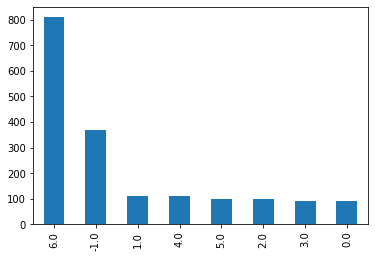

In [286]:
# Check Individual Lable's Distribution
attributes['neck'].value_counts().plot.bar()

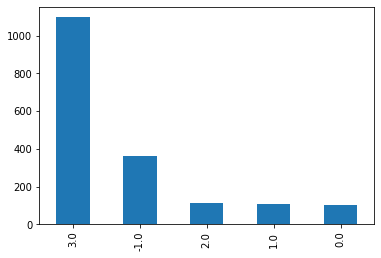

In [287]:
attributes['sleeve_length'].value_counts().plot.bar()

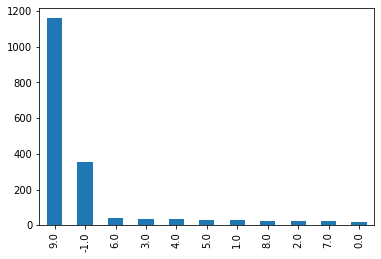

In [288]:
attributes['pattern'].value_counts().plot.bar()

In [289]:
print("Neck Null Vals: "+str(attributes['neck'].isnull().sum()))
print("Pattern Null Vals: "+str(attributes['pattern'].isnull().sum()))
print("Sleeve Length Null Vals: "+str(attributes['sleeve_length'].isnull().sum()))

Neck Null Vals: 0
Pattern Null Vals: 0
Sleeve Length Null Vals: 0


In [290]:
# One Hot Encode the Values
attributes = pd.get_dummies(attributes, columns = ['neck',
                                                   'pattern',
                                                   'sleeve_length'],
                            drop_first=True)

In [291]:
attributes

,filename,neck_0.0,neck_1.0,neck_2.0,neck_3.0,neck_4.0,neck_5.0,neck_6.0,pattern_0.0,pattern_1.0,pattern_2.0,pattern_3.0,pattern_4.0,pattern_5.0,pattern_6.0,pattern_7.0,pattern_8.0,pattern_9.0,sleeve_length_0.0,sleeve_length_1.0,sleeve_length_2.0,sleeve_length_3.0
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,11516770810185-Splash-Men-Tshirts-767151677081...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5,11505295751483-FOREVER-21-Men-White-Self-Desig...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216,11503030359861-Blackberrys-Men-Black-Solid-Man...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2217,11495782729779-Roadster-Men-Black-Printed-V-Ne...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2218,11507360109998-Nautica-Men-Blue-Striped-V-Neck...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2219,8f236dcd-4a2b-49ff-9229-981e7db946f91537273774...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Loading in PyTorch

In [292]:
# Splitting into Training, Testing and Validation Datasets
msk = np.random.rand(len(attributes)) < 0.8
train = attributes[msk]
test = attributes[~msk]

msk = np.random.rand(len(test)) < 0.5
validation = test[msk]
test = test[~msk]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [293]:
print(train.shape)
print(test.shape)
print(validation.shape)

(1428, 22)
(159, 22)
(195, 22)


In [294]:
from torchvision.io import read_image
import torch.utils.data as data

attribute_path= '/content/drive/MyDrive/Colab Notebooks/FlixStock Assignment/classification-assignment/attributes.csv'
class MyCustomDataset(data.Dataset):
# __init__ function is where the initial logic happens like reading a csv,
# assigning transforms etc.

  def __init__(self, dataf,transform):

    # Transforms
    self.transform = transform

    # Load dataframe
    data_info = dataf
    # First column contains the image paths
    self.image_arr = np.asarray(data_info.iloc[1:, 0])
    # Second and other columns are the labels
    self.label_arr = np.asarray(data_info.iloc[1:, 1:])
    self.label_arr = self.label_arr.tolist()
    self.label_arr = torch.tensor(self.label_arr, dtype=torch.float32)

    # Calculate Length 
    self.data_len = len(data_info.index)


# __getitem__ function returns the data and labels
  def __getitem__(self, index):

    # Get image name from the pandas df
    single_image_name = self.image_arr[index-1]
    # Open image
    img_as_img = Image.open(str("images/"+single_image_name))
    # Apply the transformation filters 
    img_as_tensor = self.transform(img_as_img)


    # Get label(class) of the image based on the cropped pandas column
    single_image_label = self.label_arr[index-1]

    return (img_as_tensor, single_image_label)

  def __len__(self):
    return self.data_len

  def getImagesList(self):
    return self.label_arr

In [295]:
# transforms 
transformer =  transforms.Compose(
    [
     transforms.Resize((512, 512)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     # 0.5,0.5,0.5 gave the F1 score as 0.60
     # These values come from ImageNet's normalization score, 
    ]
      )
transformer_test =  transforms.Compose(
    [
     transforms.Resize((512, 512)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
      )

In [296]:
training_dataset = MyCustomDataset(train,transform=transformer)
testing_dataset = MyCustomDataset(test,transform=transformer_test)
validation_dataset = MyCustomDataset(validation,transform=transformer)

list_images_training = training_dataset.getImagesList()
list_images_validation = validation_dataset.getImagesList()
list_images_testing = training_dataset.getImagesList()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.])


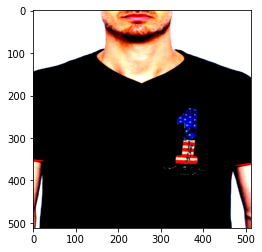

In [297]:
temp_img, temp_lab = training_dataset[4]
print(temp_lab)
plt.imshow(temp_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.])


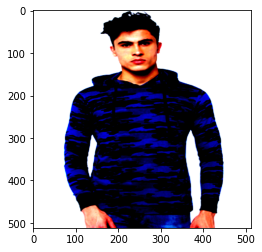

In [298]:
temp_img, temp_lab = testing_dataset[2]
print(temp_lab)
plt.imshow(temp_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1.])


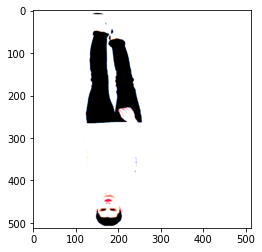

In [299]:
temp_img, temp_lab = validation_dataset[4]
print(temp_lab)
plt.imshow(temp_img.permute(1, 2, 0))

In [300]:
# HyperParamter 1 - Tweak for further model improvement
batch_size = 16

In [313]:
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size= batch_size,shuffle=True)
test_dataloader = DataLoader(testing_dataset, shuffle=True)

In [302]:
batch = next(iter(train_dataloader))
print('len:', len(batch))
images, labels = batch
print('types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)

len: 2
types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([16, 3, 512, 512]) torch.Size([16, 21])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 512, 512])
Labels batch shape: torch.Size([16, 21])


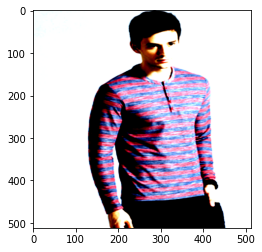

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.])


In [303]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

## Transfer Learning

In [304]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    count = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                dataloader = validation_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            f1_metric = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                count+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.sigmoid(outputs)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                outputs = outputs.cpu().detach().numpy()
                outputs = np.array(outputs > 0.5, dtype = float)
                preds = outputs
                targets = labels.data.cpu().detach().numpy()
                running_corrects += (sum(sum(preds==targets)))
                f1_metric += f1_score(y_true=targets, y_pred=preds, average='micro')

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/(count)
            epoch_acc = running_corrects/(count*16*21)
            epoch_f1 = f1_metric/(count)
            count = 0

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                count = 0


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:.4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [305]:
#model_ft = models.resnet18(pretrained=True)
model_ft = models.resnext50_32x4d(pretrained=True)
#mobilenet_v3_large
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs,21)
model_ft = model_ft.to(device)
criterion = nn.BCELoss()
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [306]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [307]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2527 Acc: 0.8969 F1: 0.5685
val Loss: 0.2411 Acc: 0.8537 F1: 0.5570
Epoch 1/24
----------
train Loss: 0.2287 Acc: 0.9036 F1: 0.5992
val Loss: 0.2342 Acc: 0.8549 F1: 0.5621
Epoch 2/24
----------
train Loss: 0.2212 Acc: 0.9055 F1: 0.5917
val Loss: 0.2237 Acc: 0.8530 F1: 0.5671
Epoch 3/24
----------
train Loss: 0.2163 Acc: 0.9077 F1: 0.6048
val Loss: 0.2283 Acc: 0.8484 F1: 0.4671
Epoch 4/24
----------
train Loss: 0.2139 Acc: 0.9087 F1: 0.6038
val Loss: 0.2311 Acc: 0.8519 F1: 0.5357
Epoch 5/24
----------
train Loss: 0.2108 Acc: 0.9092 F1: 0.6126
val Loss: 0.2254 Acc: 0.8544 F1: 0.5442
Epoch 6/24
----------
train Loss: 0.2087 Acc: 0.9084 F1: 0.5996
val Loss: 0.2212 Acc: 0.8503 F1: 0.5237
Epoch 7/24
----------
train Loss: 0.1979 Acc: 0.9119 F1: 0.6202
val Loss: 0.2217 Acc: 0.8498 F1: 0.5652
Epoch 8/24
----------
train Loss: 0.1966 Acc: 0.9122 F1: 0.6246
val Loss: 0.2157 Acc: 0.8507 F1: 0.5656
Epoch 9/24
----------
train Loss: 0.1963 Acc: 0.9118 F1: 0.6263


## Check Test Data

In [308]:
dummies_list=list(attributes.iloc[:,1:].columns)

In [314]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    dataloader = test_dataloader
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.cpu().detach().numpy()
            outputs = np.array(outputs > 0.5, dtype = float)
            preds = outputs

            for j in range(inputs.size()[0]):
                #title_of_graph = convert_preds(preds[j])
                predictions = preds[j].tolist()
                labels_listone=sum(labels.tolist(), [])
                indices = [i for i, x in enumerate(predictions) if x == 1]
                indices_labels = [i for i, x in enumerate(labels_listone) if x == 1]
                res_list = [dummies_list[i] for i in indices]
                labels_list = [dummies_list[i] for i in indices_labels]
                print("Ground Truth => " )
                print(labels_list)
                print("Model Output => ")
                print(res_list)
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Ground Truth => 
['neck_6.0', 'pattern_9.0', 'sleeve_length_3.0']
Model Output => 
['pattern_9.0', 'sleeve_length_3.0']


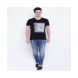

Ground Truth => 
['neck_4.0', 'pattern_9.0', 'sleeve_length_3.0']
Model Output => 
['neck_6.0', 'sleeve_length_3.0']


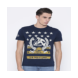

Ground Truth => 
['neck_2.0', 'pattern_9.0', 'sleeve_length_3.0']
Model Output => 
['pattern_9.0', 'sleeve_length_3.0']


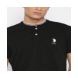

Ground Truth => 
['neck_2.0', 'pattern_9.0', 'sleeve_length_3.0']
Model Output => 
['pattern_9.0', 'sleeve_length_3.0']


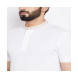

Ground Truth => 
['neck_4.0', 'pattern_9.0', 'sleeve_length_3.0']
Model Output => 
['pattern_9.0', 'sleeve_length_3.0']


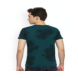

Ground Truth => 
['neck_0.0', 'sleeve_length_3.0']
Model Output => 
['pattern_9.0', 'sleeve_length_3.0']


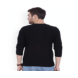

In [315]:
visualize_model(model_ft)

## Work Left

The following tasks couldn't be finished, but I am sure it would have been done, provided sufficient time.

1.   The inference script couldn't be developed. Instead, some predictions were shown on the test dataset in this notebook itself. 
2.   A single parameter-dictionary could have been added in order to make the worklfow more automated.
3.   Experiment logging was not done, adding them could have helped analyze more hyperparamters and infer from more stats such as confusion matrix.
4.   "N/A" was treated here as "-1", basically treating it as a separate class. Imputing them with mean or dropping the columns would have added additional bias. Also while predicting the same on the test data, a function could have been added which would make sure that if a predicted "1" is not found in the predicted list, it would infer it as "N/A".
5.    Fine-Tuning the models were also tried by un-freezing the layers, but since the training took more time so it wasn't completed. However, functionality is added.
6.    I wanted to implement a different type of architecture, which can be seen in the JPEG file below. However, I was not able to implement it. It bascially would have been 3 Models within a single one. (Just like Flixstock treats individual tasks using individual models, fully connected in a single NN).
7.     Training could have been faster using autoencoded/compressed images, will probably try that later.

